# Проект по Python for Data Analysis

Датасет состоит из данных сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет.
По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('real_estate_data.csv', encoding='utf-8', sep='\t')

## Этап 1. Предварительная обработка

### Общий обзор данных

In [7]:
pd.set_option('display.max_columns',50)
pd.set_option('display.max_rows', None)
df.head(2)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.7,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [9]:
#Вывод количества пропущенных значений в каждом столбце
null_value_in_column = df.isnull().sum()
for i, (column, null_count) in enumerate(null_value_in_column.sort_values(ascending=False).items(), start=1):
    if null_count > 0:
        percent = round(null_count * 100 / len(df), 1)
        print(f"{i}. {column}: пропусков {null_count} ({percent}%)")

1. is_apartment: пропусков 20924 (88.3%)
2. parks_nearest: пропусков 15620 (65.9%)
3. ponds_nearest: пропусков 14589 (61.6%)
4. balcony: пропусков 11519 (48.6%)
5. ceiling_height: пропусков 9195 (38.8%)
6. airports_nearest: пропусков 5542 (23.4%)
7. cityCenters_nearest: пропусков 5519 (23.3%)
8. ponds_around3000: пропусков 5518 (23.3%)
9. parks_around3000: пропусков 5518 (23.3%)
10. days_exposition: пропусков 3181 (13.4%)
11. kitchen_area: пропусков 2278 (9.6%)
12. living_area: пропусков 1903 (8.0%)
13. floors_total: пропусков 86 (0.4%)
14. locality_name: пропусков 49 (0.2%)


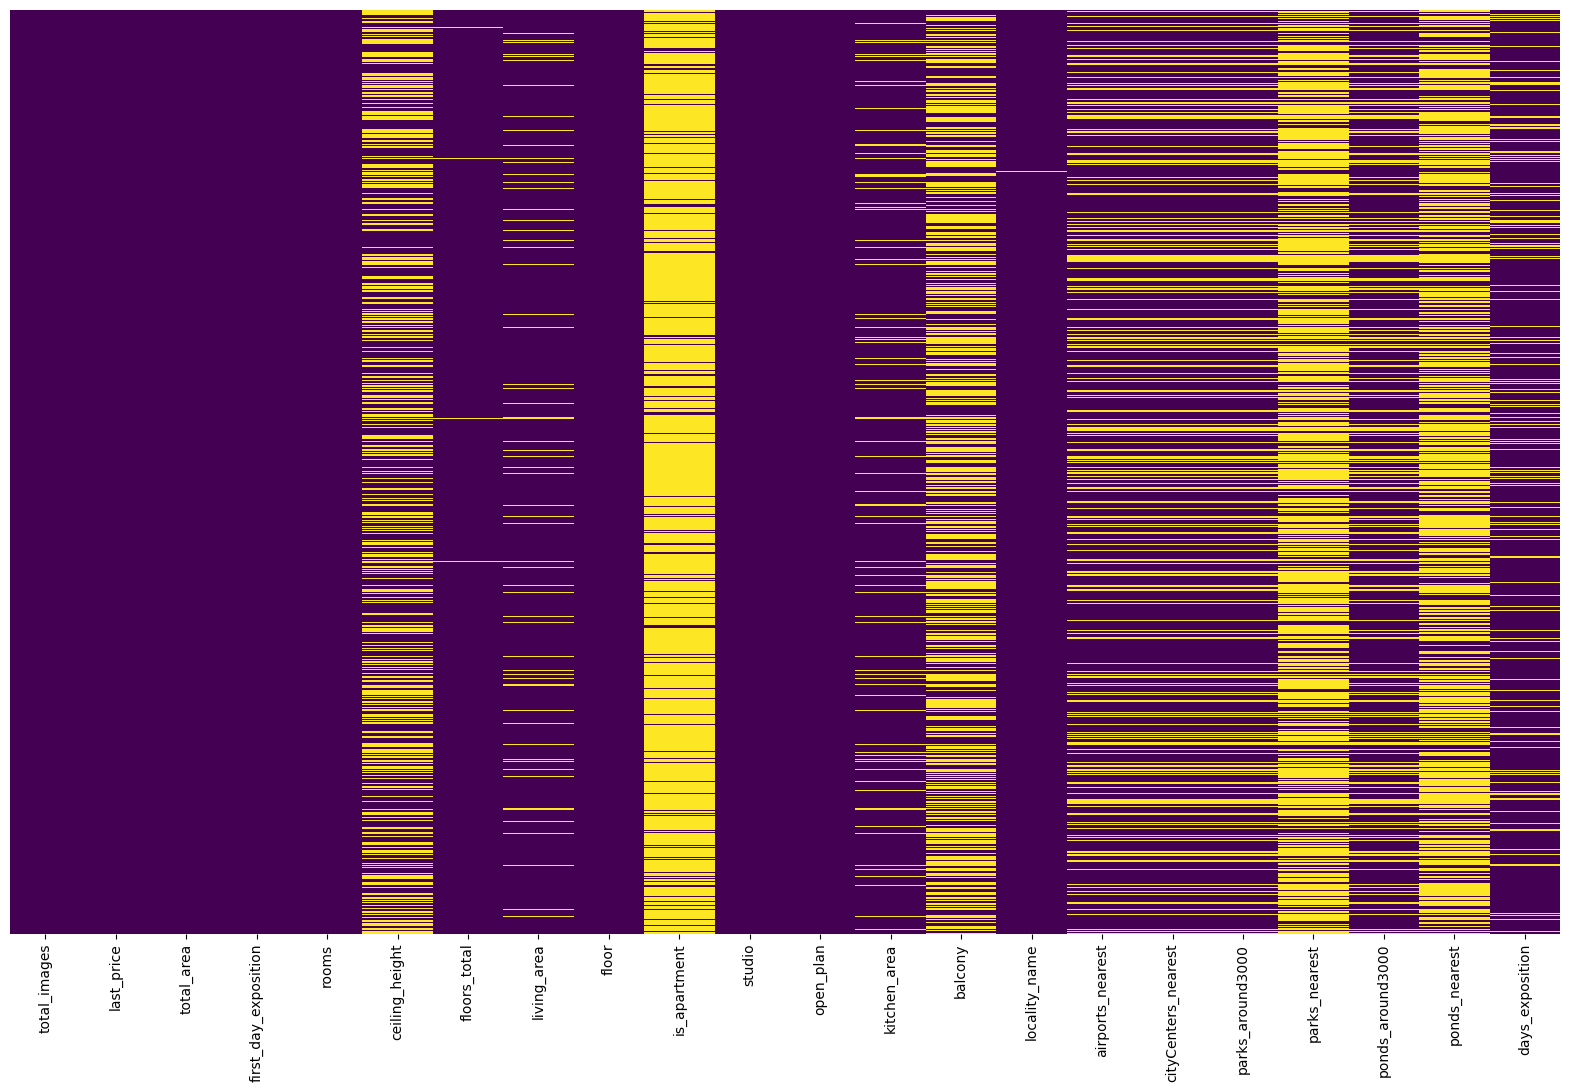

In [10]:
# График пустых значений
fig, ax = plt.subplots(figsize=(20,12))
sns_heatmap = sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [11]:
#проверка на дубликаты
print(f'Количество строк дубликатов: {df.duplicated().sum()}') 

Количество строк дубликатов: 0


In [12]:
#сохраним размера df для сравнения после обработки
len_df_start = len(df)

### Детальный обзор каждого параметра

В анализе каждого параметра выполнены следующие шаги:

    1. Обзор всех уникальных значений для визуальной оценки корректности данных данных. 
    2. Подсчет кол-ва пропусков. Где было возможно, сделаны замены пропусков.
    3. Построение гистограммы для поиска аномалий и в некоторых случаях удаление выбросов.
    4. Замена типа данных, где было необходимо.

Результаты обработки по каждому параметру:
1. total_images - удалены строки с редкими значениями (99% персентиль)
2. last_price - удалены строки с редкими значениями (99% персентиль), значения округлены до целого числа.
3. total_area - удалены строки с редкими значениями (99% персентиль)
4. first_day_exposition - удалена временная метка, осталась только дата.
5. rooms - значение 0 заменено на 1, удалены строки с редкими значениями (99% персентиль)
6. ceiling_height - пропущенные значения заменены на среднее значение, удалены строки с редкими значениями (99% персентиль)
7. floors_total - приведен к типу int, удалены все строки с пропусками, удалены строки с редкими значениями (99% персентиль)
8. living_area - пропуски заменены на среднее значение этого параметра с той же общей площадью, удалены строки с редкими значениями (99% персентиль), округение до 2-знаков после запятой
9. floor - без изменений
10. is_apartment - столбец удален, так как пропущено 88% значений, неизвестно на какое значение заменить пропуски.
11. studio - без изменений
12. open_plan - без изменений
13. balcony - заменены пропущенные значения на 0 (нет балкона), приведен к типу int
14. kitchen_area - пропуски заменены на среднюю долю кухни от нежилой зоны по всем строкам
15. airports_nearest - без измнений, в том числе оставлены пропуски
16. cityCenters_nearest - без измнений, в том числе оставлены пропуски
17. days_exposition -  заменены пропущенные значения на 0, приведен к типу int
18. locality_name - заменены дубликаты названий, пропуски оставлены
19. parks_nearest - сделаны замены пропусков на 3100 в тех строках, где известно, что в радиусе 3 км нет парка, остались пропуски
20. ponds_nearest - сделаны замены пропусков на 3100 в тех строках, где известно, что в радиусе 3 км нет водоема, остались пропуски
21. parks_around3000 - без изменений, остались пропуски
22. ponds_around3000 - без изменений, остались пропуски

#### total_images

In [17]:
# просмотр уникальных значений
df['total_images'].value_counts()

total_images
10    1798
9     1725
20    1694
8     1585
7     1521
6     1482
11    1362
5     1301
12    1225
0     1059
13    1015
4      986
14     986
15     948
1      872
3      769
16     761
17     650
18     642
2      640
19     603
23      16
21      12
24       8
22       8
26       5
32       4
28       4
50       3
29       3
27       2
30       2
35       2
31       2
42       1
25       1
39       1
37       1
Name: count, dtype: int64

In [18]:
# количество пустых значений
print(f'Количество пустых значений {df['total_images'].isnull().sum()}')

Количество пустых значений 0


<Axes: >

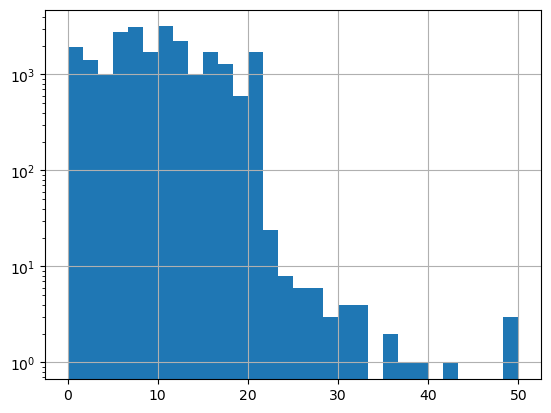

In [19]:
#поиск аномалий
df['total_images'].hist(bins=30, log=True)

<Axes: >

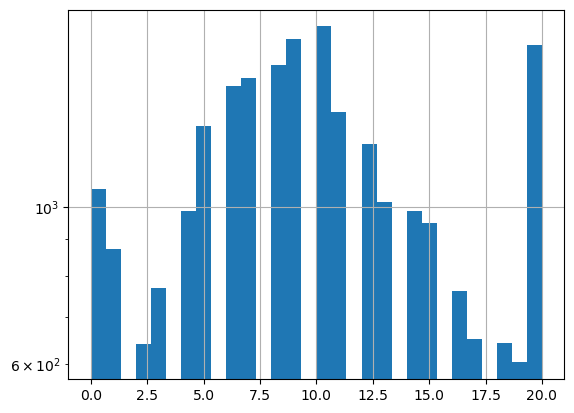

In [20]:
#Уберем 1% аномальных значений. Воспользуемся 99% персентилем
threshold = df['total_images'].quantile(0.99)
df = df[df.total_images <= threshold]
# Визуализируем
df['total_images'].hist(bins=30, log=True)

#### last_price

In [22]:
#Просмотрим уникальные значения
df['last_price'].value_counts()

last_price
4500000.0      341
3500000.0      291
4000000.0      260
4300000.0      260
4200000.0      259
3600000.0      256
3300000.0      244
3800000.0      240
3200000.0      238
3700000.0      233
4100000.0      232
3400000.0      227
5500000.0      226
3900000.0      221
3100000.0      220
4600000.0      215
5200000.0      205
4800000.0      198
5000000.0      198
5100000.0      192
5300000.0      192
4700000.0      190
4900000.0      190
3000000.0      182
6500000.0      178
4400000.0      177
3650000.0      164
2900000.0      161
3950000.0      157
6000000.0      151
2800000.0      150
4150000.0      149
5600000.0      145
7500000.0      143
2700000.0      140
3150000.0      140
5800000.0      139
3750000.0      139
2600000.0      135
5400000.0      134
2500000.0      133
6200000.0      131
3850000.0      129
6300000.0      125
4950000.0      124
8500000.0      124
4650000.0      123
2950000.0      123
3550000.0      123
4250000.0      120
4350000.0      120
5900000.0      119
5

In [23]:
#Количество пустых значений
print(f'Количество пустых значений {df['last_price'].isnull().sum()}')

Количество пустых значений 0


<Axes: >

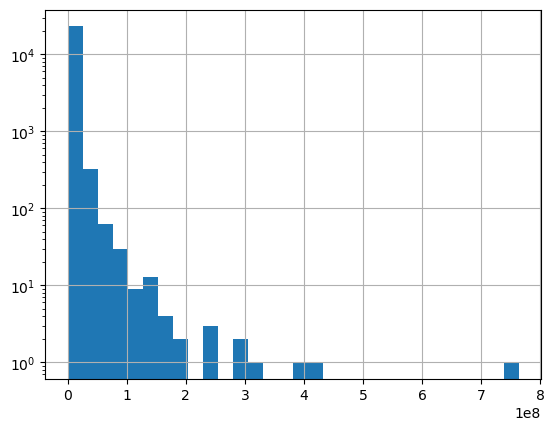

In [24]:
#Поиск аномалий
df['last_price'].hist(bins=30, log=True)

<Axes: >

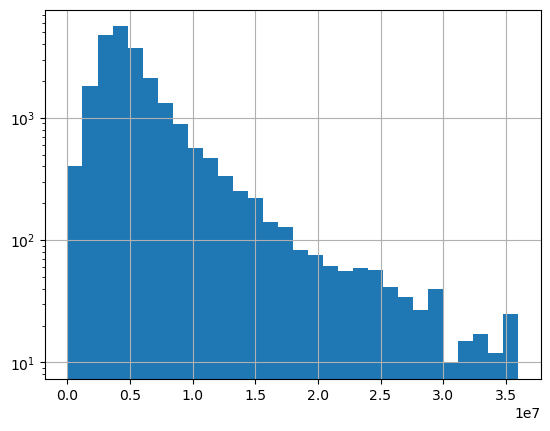

In [25]:
#Уберем 1% аномальных значений. Воспользуемся 99% персентилем
threshold = df['last_price'].quantile(0.99)
df = df[df.last_price <= threshold]

# Визуализируем
df['last_price'].hist(bins=30, log=True)

In [26]:
# Округление до целого
df['last_price'] = df['last_price'].round(0)

#### total_area

In [28]:
#Уникальные значения
df['total_area'].value_counts()

total_area
45.00     418
42.00     383
60.00     347
31.00     346
44.00     344
40.00     315
43.00     300
32.00     289
46.00     282
50.00     279
36.00     278
35.00     262
38.00     237
41.00     227
55.00     227
33.00     224
34.00     218
54.00     217
58.00     217
52.00     216
37.00     213
39.00     210
30.00     205
57.00     201
62.00     193
48.00     190
47.00     188
70.00     181
80.00     174
56.00     173
72.00     167
51.00     167
53.00     167
63.00     161
59.00     151
65.00     147
61.00     140
49.00     134
64.00     132
75.00     129
74.00     124
67.00     115
68.00     111
73.00     104
66.00      93
69.00      84
29.00      81
90.00      80
71.00      78
76.00      76
78.00      76
100.00     72
85.00      69
82.00      66
44.50      61
79.00      60
77.00      59
95.00      59
83.00      59
28.00      56
45.50      54
98.00      48
87.00      48
31.20      47
35.50      46
84.00      45
25.00      45
81.00      44
86.00      44
43.50      44
31.50    

In [29]:
#Количество пустых значений
print(f'Количество пустых значений {df['total_area'].isnull().sum()}')

Количество пустых значений 0


<Axes: >

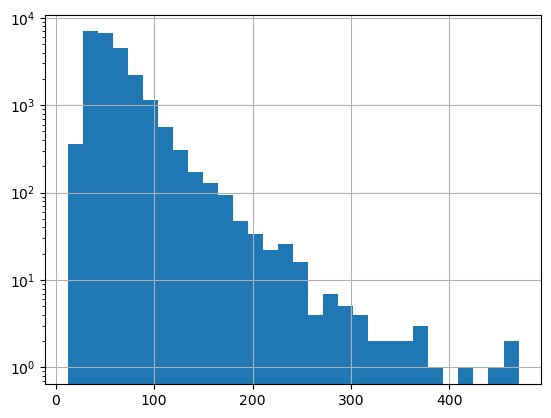

In [30]:
#Поиск аномалий
df['total_area'].hist(bins=30, log=True)

<Axes: >

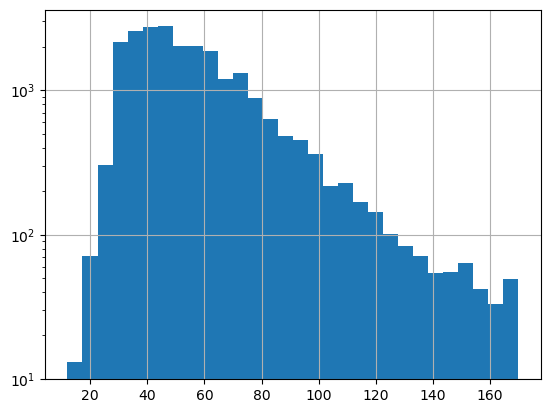

In [31]:
#Уберем 1% аномальных значений. Воспользуемся 99% персентилем
threshold = df['total_area'].quantile(0.99)
df = df[df.total_area <= threshold]

# Визуализируем
df['total_area'].hist(bins=30, log=True)

#### first_day_exposition

In [33]:
#Уникальные значения
df['first_day_exposition'].value_counts()

first_day_exposition
2018-02-01T00:00:00    357
2017-11-10T00:00:00    225
2017-10-13T00:00:00    122
2017-09-27T00:00:00    103
2018-03-26T00:00:00     95
2018-07-10T00:00:00     92
2017-09-28T00:00:00     72
2018-03-06T00:00:00     71
2018-01-12T00:00:00     70
2018-02-20T00:00:00     68
2018-02-08T00:00:00     68
2018-03-23T00:00:00     66
2017-04-14T00:00:00     63
2017-09-26T00:00:00     61
2018-03-15T00:00:00     58
2017-11-29T00:00:00     58
2018-09-11T00:00:00     57
2018-02-13T00:00:00     57
2017-08-09T00:00:00     55
2019-04-04T00:00:00     54
2018-01-01T00:00:00     53
2017-10-03T00:00:00     53
2017-04-20T00:00:00     53
2017-11-16T00:00:00     52
2017-11-09T00:00:00     52
2017-12-07T00:00:00     51
2019-03-26T00:00:00     51
2017-06-02T00:00:00     50
2018-01-15T00:00:00     50
2017-06-29T00:00:00     50
2017-11-22T00:00:00     50
2019-04-22T00:00:00     50
2017-12-06T00:00:00     49
2017-12-08T00:00:00     49
2019-04-18T00:00:00     49
2017-10-26T00:00:00     49
2019-03

In [34]:
#Количество пустых значений
print(f'Количество пустых значений {df['first_day_exposition'].isnull().sum()}')

Количество пустых значений 0


In [35]:
#Оставим только дату, так как все временные метки одинаковы
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition']).dt.normalize()

#### rooms

In [37]:
# Уникальные значения
df['rooms'].value_counts()

rooms
1    8031
2    7903
3    5694
4    1066
5     219
0     195
6      43
7      13
8       1
Name: count, dtype: int64

In [38]:
# Количество пустых значений
print(f'Количество пустых значений {df['rooms'].isnull().sum()}')

Количество пустых значений 0


Есть строки с числом комнат 0, что не может быть. Проанализируем и сделаем замену:

In [40]:
#Сгруппируем кол-во комнат по размеру жилой зоны
df.groupby('rooms')['living_area'].mean()

rooms
0     18.859011
1     17.884060
2     31.696111
3     46.904826
4     62.744102
5     83.256650
6     97.287805
7     98.275000
8    107.000000
Name: living_area, dtype: float64

In [41]:
#Заменим число комнат с 0 на 1, так как они имеют схожее значение по параметру размер жилой площади
df['rooms'] = df['rooms'].replace(0, 1)

<Axes: >

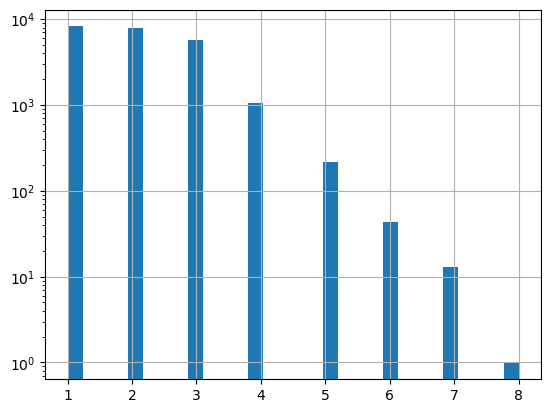

In [42]:
#поиск аномалий
df['rooms'].hist(bins=30, log=True)

<Axes: >

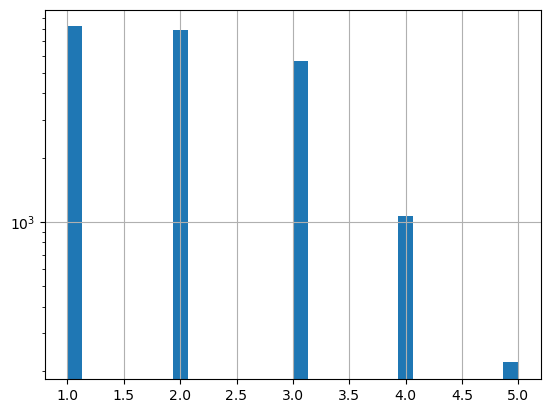

In [43]:
#Уберем 1% аномальных значений. Воспользуемся 99% персентилем
threshold = df['rooms'].quantile(0.99)
df = df[df.rooms <= threshold]

# Визуализируем
df['rooms'].hist(bins=30, log=True)

#### ceiling_height

In [45]:
#Уникальные значения
df['ceiling_height'].value_counts()

ceiling_height
2.50      3509
2.60      1641
2.70      1564
3.00      1048
2.80       981
2.55       975
2.75       900
2.65       675
3.20       246
3.10       187
2.90       156
2.56       138
3.30       114
2.57       101
3.50       101
2.85        97
2.54        83
2.64        81
2.52        79
3.40        76
2.53        67
2.58        63
2.76        60
2.77        60
3.15        54
2.78        51
2.95        43
3.05        42
2.67        36
3.25        35
2.73        34
2.51        34
4.00        30
2.72        30
3.60        29
2.74        28
3.70        24
2.40        23
2.68        23
3.80        19
2.84        19
2.82        18
2.66        17
2.45        15
3.12        15
3.55        14
2.83        14
2.59        14
2.63        13
2.71        13
2.62        13
3.08        12
3.35        12
2.88        12
3.07        11
2.00        11
3.06        11
3.18        10
2.87        10
3.13        10
2.79        10
4.20         9
3.45         9
3.90         9
3.02         8
2.81      

In [46]:
# В уникальных значениях высоты потолока есть двузначные значения 24.00, вероятно, здесь ошибка в указании десятой части. Сделаем замену
df['ceiling_height'] = df['ceiling_height'].apply(lambda x: x / 10 if x > 10 else x)

In [47]:
# Количество пустых значений
print(f'Количество пустых значений {df['ceiling_height'].isnull().sum()}')

Количество пустых значений 8974


In [48]:
print(f'Cреднее = {df['ceiling_height'].mean()}')
print(f'Медиана = {df['ceiling_height'].median()}')

Cреднее = 2.714313711617377
Медиана = 2.65


In [49]:
#Заменим пустые значения средним по всей выборке
df['ceiling_height'] = df['ceiling_height'].fillna(round(df['ceiling_height'].mean(),2))

<Axes: >

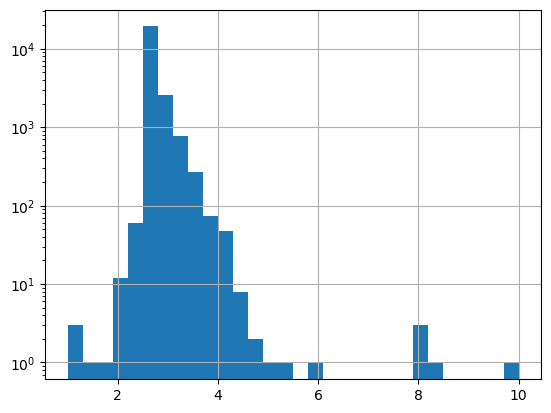

In [50]:
#Поиск аномалий
df['ceiling_height'].hist(bins=30, log=True)

<Axes: >

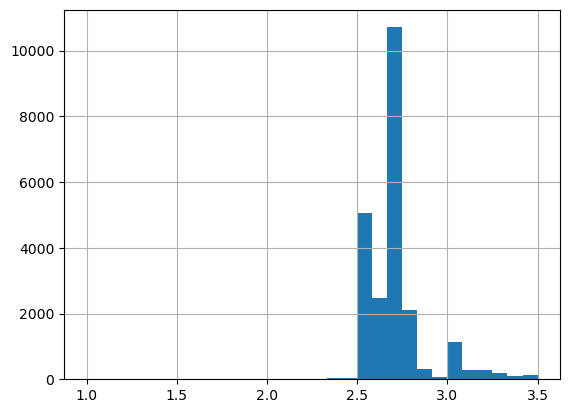

In [51]:
#Уберем 1% аномальных значений. Воспользуемся 99% персентилем
threshold = df['ceiling_height'].quantile(0.99)
df = df[df.ceiling_height <= threshold]

# Визуализируем
df['ceiling_height'].hist(bins=30)

#### floors_total

In [53]:
# просмотр уникальных значений
df['floors_total'].value_counts()

floors_total
5.0     5585
9.0     3729
16.0    1353
12.0    1338
10.0    1156
4.0     1090
25.0    1064
17.0     824
6.0      776
3.0      620
14.0     546
7.0      532
18.0     499
24.0     464
2.0      364
15.0     358
23.0     348
8.0      341
19.0     335
22.0     283
20.0     262
13.0     225
11.0     196
27.0     164
21.0     157
26.0     123
1.0       25
35.0      24
28.0      21
36.0       3
34.0       1
60.0       1
29.0       1
33.0       1
52.0       1
37.0       1
Name: count, dtype: int64

In [54]:
# Количество пустых значений
print(f'Количество пустых значений {df['floors_total'].isnull().sum()}')

Количество пустых значений 84


In [55]:
#Удалим строки с пустыми значенями, так как их меньше 0,5%
df = df.dropna(subset=['floors_total'])

In [56]:
#Приведем значения к типу int
df['floors_total'] = df.floors_total.astype(int)

<Axes: >

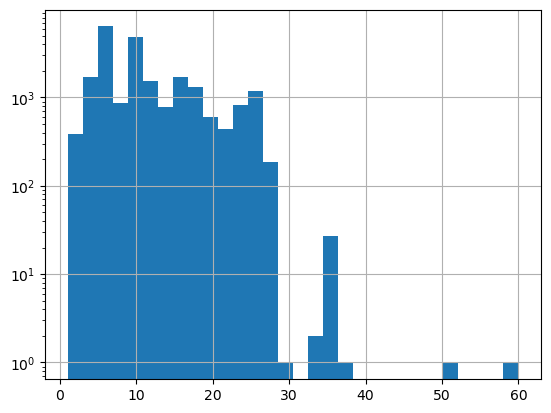

In [57]:
#Поиск аномалий
df['floors_total'].hist(bins=30, log=True)

<Axes: >

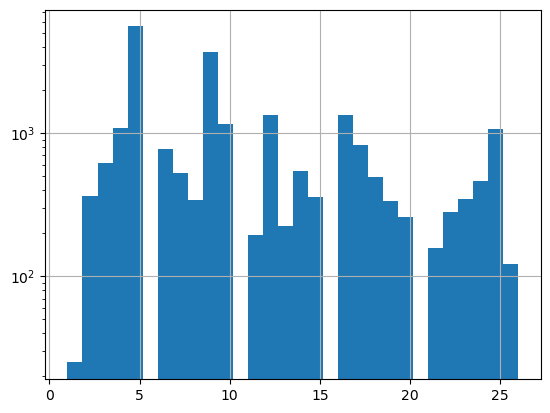

In [58]:
#Уберем 1% аномальных значений. Воспользуемся 99% персентилем
threshold = df['floors_total'].quantile(0.99)
df = df[df.floors_total <= threshold]

# Визуализируем
df['floors_total'].hist(bins=30, log=True)

#### living_area 

In [60]:
# Просмотр уникальных значений
df['living_area'].value_counts()

living_area
18.000000     869
17.000000     665
30.000000     589
16.000000     474
20.000000     473
28.000000     418
31.000000     372
19.000000     323
29.000000     316
32.000000     313
27.000000     308
15.000000     307
43.000000     226
40.000000     218
42.000000     212
33.000000     211
35.000000     192
34.000000     184
39.000000     182
36.000000     168
17.500000     168
44.000000     166
38.000000     157
45.000000     145
37.000000     138
21.000000     135
41.000000     129
47.000000     129
48.000000     128
50.000000     124
26.000000     120
14.000000     110
46.000000     109
18.500000     105
25.000000     102
17.800000      99
49.000000      96
17.700000      94
17.600000      94
22.000000      94
18.600000      94
17.400000      90
16.500000      88
17.200000      86
54.000000      80
53.000000      79
52.000000      76
15.500000      72
17.300000      72
17.100000      71
18.200000      70
60.000000      69
29.500000      69
18.300000      68
56.000000      6

In [61]:
# Проверка на пропущенные значения
print(f'Количество пропущенных значений: {df['living_area'].isna().sum()}')

Количество пропущенных значений: 1789


In [62]:
# Найдем среднее значение жилой зоны для округленного значения всей площади
df.groupby(df['total_area'].round())['living_area'].mean()

total_area
12.0      10.000000
13.0      10.000000
14.0      11.000000
15.0            NaN
16.0      11.500000
17.0      12.500000
18.0      13.270000
19.0      15.600000
20.0      14.900000
21.0      13.835385
22.0      14.111154
23.0      15.275556
24.0      16.291509
25.0      17.531765
26.0      17.123051
27.0      17.226346
28.0      17.351183
29.0      16.264342
30.0      16.695043
31.0      16.887315
32.0      17.329013
33.0      16.957208
34.0      17.049846
35.0      17.131674
36.0      17.475436
37.0      17.678973
38.0      18.116906
39.0      18.609171
40.0      18.988882
41.0      20.450464
42.0      22.700107
43.0      22.936278
44.0      25.530453
45.0      26.402204
46.0      26.565884
47.0      26.020283
48.0      26.840340
49.0      28.937149
50.0      28.981193
51.0      29.126742
52.0      29.422630
53.0      30.022231
54.0      30.799767
55.0      33.149109
56.0      33.851926
57.0      34.866029
58.0      35.341742
59.0      36.061566
60.0      37.287697
61.0     

In [63]:
# Замена пропусков средним значением для тех же total_area
df['living_area'] = df.groupby(df['living_area'].round())['living_area'].transform(lambda group: group.fillna(group.mean()))

Остались пропуски в нескольких living_area. В строках с total_area 15.0 сделаем замену на среднее значение в living_area с total_area 14.0 

In [65]:
df.loc[df['total_area'].round() == 15, 'living_area'] = 11

<Axes: >

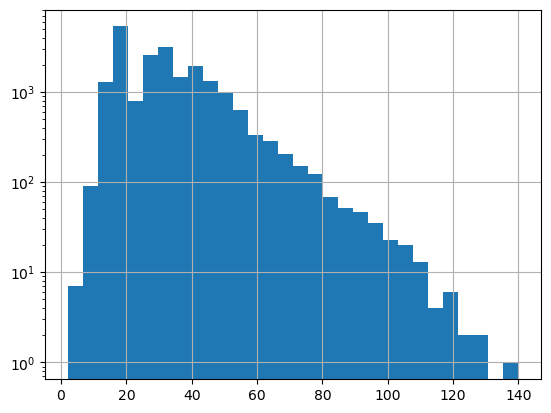

In [66]:
#Поиск выбросов
df['living_area'].hist(bins=30, log=True)

<Axes: >

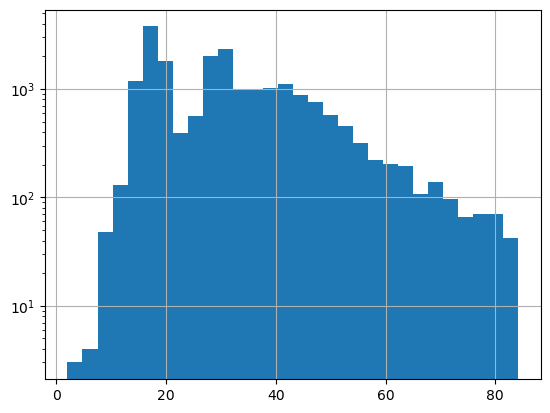

In [67]:
#Уберем 1% аномальных значений. Воспользуемся 99% персентилем
threshold = df['living_area'].quantile(0.99)
df = df[df['living_area'] <= threshold]

# Визуализируем
df['living_area'].hist(bins=30, log=True)

In [68]:
#округлим до двух знаков после запятой
df['living_area'] = df['living_area'].round(2)

#### floor

In [70]:
# Просмотр уникальных значений
df['floor'].value_counts()

floor
2     2901
3     2647
1     2589
4     2417
5     2286
6     1133
7     1078
8      965
9      952
10     608
11     464
12     458
13     326
14     300
15     292
16     277
17     195
18     144
19     117
21     104
22      90
20      90
23      79
24      47
25      33
26       6
Name: count, dtype: int64

In [71]:
# проверка на пропущенные значения
print(f'Количество пропущенных значений: {df.floor.isna().sum()}')

Количество пропущенных значений: 0


#### is_apartment

In [73]:
#Уникальные значения
df['is_apartment'].value_counts() 

is_apartment
False    2475
True       32
Name: count, dtype: int64

In [74]:
# Проверка на пропущенные значения
print(f'Количество пропущенных значений: {df['is_apartment'].isna().sum()}')

Количество пропущенных значений: 18091


Невозможно определить значение. Так как остается большое количество пропущенных строк, то удалим этот столбец.

In [76]:
df.drop(columns=['is_apartment'], inplace=True)

#### studio

In [78]:
# Просмотр уникальных значений
df['studio'].value_counts()

studio
False    20462
True       136
Name: count, dtype: int64

In [79]:
# Проверка на пропущенные значения
print(f'Количество пропущенных значений: {df['studio'].isna().sum()}')

Количество пропущенных значений: 0


#### open_plan

In [81]:
# Просмотр уникальных значений
df['open_plan'].value_counts()

open_plan
False    20538
True        60
Name: count, dtype: int64

In [82]:
# проверка на пропущенные значения
print(f'Количество пропущенных значений: {df['open_plan'].isna().sum()}')

Количество пропущенных значений: 0


#### balcony

In [84]:
# Просмотр уникальных значений
df['balcony'].value_counts()

balcony
1.0    3867
2.0    3384
0.0    3362
5.0     270
4.0     156
3.0      68
Name: count, dtype: int64

In [85]:
#Проверяем кол-во пропусков
print(f'Кол-во пропусков в balcony: {df['balcony'].isna().sum()}')

Кол-во пропусков в balcony: 9491


In [86]:
# Заменим отсутствующие значения в столбце balcony на 0
df['balcony'] = df['balcony'].fillna(0)

In [87]:
# Поменяем тип данных на int
df['balcony'] = df['balcony'].astype(int)

#### kitchen_area

In [89]:
# Просмотр значений
df['kitchen_area'].value_counts()

kitchen_area
6.00     1272
10.00    1170
8.00     1078
9.00     1050
7.00     1040
11.00     753
12.00     600
8.50      403
5.50      398
5.00      349
14.00     344
15.00     298
13.00     296
6.30      291
6.20      280
8.30      266
6.50      259
8.20      232
7.50      225
8.40      208
9.50      173
7.20      163
10.30     160
7.10      158
16.00     157
10.80     156
8.60      150
8.10      148
10.20     148
10.50     146
8.70      145
5.30      139
10.70     139
5.60      135
5.40      135
10.60     126
10.40     119
5.20      117
11.50     116
9.30      113
6.10      111
9.40      108
10.10     105
8.80      105
20.00     101
9.20      101
7.80      101
17.00     100
9.80       99
9.60       98
12.50      98
7.30       97
6.40       94
6.70       90
7.40       88
18.00      84
5.80       83
6.60       83
6.80       81
5.70       81
11.30      80
9.10       80
7.70       77
11.20      72
8.90       71
6.90       71
11.40      69
9.70       69
9.90       68
7.60       67
10.90  

In [90]:
# Проверка на пропущенные значения
print(f'Количество пропущенных значений: {df['kitchen_area'].isna().sum()}')

Количество пропущенных значений: 766


Определим значение для замены пропусков: рассчитаем для каждой строки разницу между total_area и living_area, а затем рассчитаем какой процент от нежилой зоны в среднем занимает кухня

In [92]:
# доля, которую в среднем занимает кухня от нежилой территории
median_kitchen_percentage = round((df['kitchen_area'] / (df['total_area'] - df['living_area'])).median(), 1)
print(f'Доля кухни от нежилой зоны в среднем равна {median_kitchen_percentage}')

Доля кухни от нежилой зоны в среднем равна 0.4


In [93]:
#для каждой строки, где известы total_area и living_area, получим значение для kitchen_area
df.loc[df['kitchen_area'].isna(), 'kitchen_area'] = df['total_area'] - df['living_area'] * median_kitchen_percentage

#### airports_nearest

In [95]:
# Просмотр уникальных значений
df['airports_nearest'].value_counts()

airports_nearest
37434.0    46
21928.0    28
39946.0    28
39140.0    23
21793.0    22
37407.0    22
44382.0    21
19499.0    21
23639.0    20
51333.0    20
30073.0    20
13461.0    20
39141.0    18
44870.0    18
12678.0    17
43074.0    17
23609.0    17
39393.0    16
37412.0    16
21460.0    16
11405.0    16
23604.0    15
34967.0    15
23617.0    15
28554.0    15
17720.0    15
18748.0    14
37625.0    14
32158.0    14
47303.0    14
35129.0    13
48847.0    13
9354.0     13
7026.0     13
35966.0    13
27314.0    13
35847.0    13
32746.0    13
18012.0    13
13908.0    12
30894.0    12
13931.0    12
17950.0    12
34201.0    12
14809.0    12
31744.0    12
14768.0    12
37948.0    12
15493.0    12
35257.0    12
10663.0    12
25987.0    12
52212.0    12
18695.0    11
14184.0    11
22077.0    11
10031.0    11
20028.0    11
28959.0    11
16087.0    11
51514.0    11
46530.0    11
33564.0    11
22089.0    11
7659.0     11
21743.0    11
23756.0    11
15339.0    11
39180.0    11
32106.0    11
365

In [96]:
# Проверка на пропущенные значения
print(f'Количество пропущенных значений: {df['airports_nearest'].isna().sum()}')

Количество пропущенных значений: 4799


In [97]:
#Оставим незаполненными, так как нет возможности заполнить

#### cityCenters_nearest

In [99]:
# Просмотр уникальных значений
df['cityCenters_nearest'].value_counts()

cityCenters_nearest
8460.0     46
10720.0    28
13845.0    23
10364.0    23
8434.0     22
16921.0    21
13056.0    21
17121.0    20
4844.0     20
10337.0    20
15985.0    20
13222.0    18
8370.0     18
17256.0    18
14883.0    18
5164.0     18
14479.0    17
20802.0    17
18465.0    17
12738.0    17
14772.0    16
19247.0    16
5223.0     16
16722.0    16
14153.0    16
11096.0    16
5299.0     16
5294.0     16
11004.0    15
16005.0    15
14640.0    15
16788.0    15
16293.0    14
12398.0    14
4087.0     14
12099.0    14
4341.0     14
5038.0     14
15853.0    14
34341.0    14
14769.0    14
7348.0     13
13149.0    13
16685.0    13
17071.0    13
16002.0    13
4358.0     13
13242.0    13
14657.0    13
8297.0     12
13606.0    12
19717.0    12
4836.0     12
16802.0    12
15945.0    12
12525.0    12
12886.0    12
10890.0    12
13073.0    12
12702.0    12
14069.0    12
19694.0    12
19242.0    12
11920.0    12
15363.0    11
15142.0    11
13841.0    11
11990.0    11
17501.0    11
11905.0    11


In [100]:
# Проверка на пропущенные значения
print(f'Количество пропущенных значений: {df['cityCenters_nearest'].isna().sum()}')

Количество пропущенных значений: 4781


In [101]:
#Оставим незаполненными, так как нет возможности заполнить

#### days_exposition

In [103]:
# Просмотр уникальных значений
df['days_exposition'].value_counts()

days_exposition
45.0      531
60.0      341
7.0       206
30.0      196
4.0       166
3.0       146
14.0      133
5.0       132
20.0      131
9.0       125
8.0       125
13.0      120
28.0      118
90.0      118
22.0      117
18.0      116
11.0      116
6.0       115
29.0      114
10.0      113
21.0      112
15.0      111
24.0      110
17.0      109
19.0      106
34.0      105
35.0      104
27.0      104
23.0      102
54.0      100
42.0       99
44.0       99
74.0       96
12.0       96
61.0       95
16.0       94
26.0       93
63.0       91
89.0       90
67.0       88
59.0       86
32.0       85
40.0       83
37.0       83
33.0       80
52.0       79
43.0       79
64.0       77
25.0       77
53.0       77
36.0       77
56.0       77
92.0       76
46.0       76
48.0       71
84.0       71
65.0       69
55.0       68
47.0       68
62.0       68
41.0       67
70.0       67
57.0       66
68.0       66
38.0       66
113.0      66
93.0       65
66.0       64
97.0       64
91.0       64
49.0

In [104]:
# Проверка на пропущенные значения
print(f'Количество пропущенных значений: {df['days_exposition'].isna().sum()}')

Количество пропущенных значений: 2732


In [105]:
#Замена пропусков
df['days_exposition'] = df['days_exposition'].fillna(0)

In [106]:
#Изменение типа данных
df['days_exposition'] = df['days_exposition'].astype('int')

<Axes: >

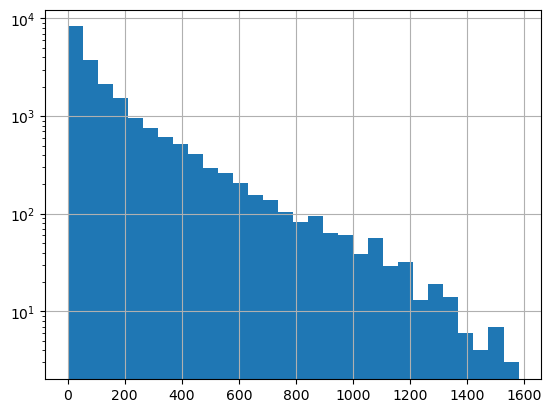

In [107]:
#Поиск выбросов
df['days_exposition'].hist(bins=30, log=True)

#### locality_name

In [109]:
# Просмотр уникальных значений
df['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'Ломоносов', 'Сертолово', 'Петергоф',
       'Пушкин', 'деревня Кудрово', 'Колпино', 'посёлок Мурино',
       'Гатчина', 'поселок Мурино', 'деревня Фёдоровское', 'Выборг',
       'Кронштадт', 'Кировск', 'деревня Новое Девяткино',
       'посёлок Металлострой', 'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'деревня Старая',
       'деревня Лесколово', 'село Путилово', 'Ивангород', 'Мурино',
       'Сланцы', 'Шлиссельбург', 'Сясьстрой', 'Никольское', 'Зеленогорск',
       'Сосновый Бор',

In [110]:
print(f'Количество уникальных значений до замены: {len(df['locality_name'].unique())}')

Количество уникальных значений до замены: 348


In [111]:
#замена названий
names_variant = {'посёлок': 'поселок',
                 'посёлок городского типа': 'поселок',
                 'поселок городского типа': 'поселок',
                 'городской поселок': 'поселок',
                 'городской посёлок': 'поселок',
                 'поселок при железнодорожной станции': 'поселок',
                 'посёлок при железнодорожной станции': 'поселок',
                 'поселок станции': 'поселок',
                 'посёлок станции': 'поселок'}
df['locality_name'] = df['locality_name'].replace(names_variant, regex=True)

In [112]:
print(f'Количество уникальных значений после замены: {len(df['locality_name'].unique())}')

Количество уникальных значений после замены: 322


In [113]:
# Проверка на пропущенные значения
print(f'Количество пропущенных значений: {df['locality_name'].isna().sum()}')

Количество пропущенных значений: 40


#### parks_nearest и parks_around3000

In [115]:
# Просмотр уникальных значений
df['parks_nearest'].value_counts()

parks_nearest
441.0     49
173.0     34
456.0     34
392.0     32
471.0     28
2102.0    28
458.0     26
541.0     24
288.0     24
398.0     23
447.0     23
192.0     23
592.0     22
601.0     22
350.0     22
485.0     22
223.0     22
570.0     22
315.0     21
310.0     21
433.0     21
194.0     21
645.0     21
721.0     20
674.0     20
533.0     20
309.0     20
620.0     20
630.0     20
212.0     20
532.0     20
483.0     19
413.0     19
537.0     19
394.0     19
604.0     19
679.0     19
498.0     19
842.0     19
215.0     19
156.0     19
428.0     19
531.0     18
51.0      18
522.0     18
367.0     18
497.0     18
172.0     18
420.0     18
343.0     18
401.0     18
440.0     18
501.0     18
684.0     18
572.0     18
365.0     18
451.0     18
672.0     18
637.0     17
513.0     17
641.0     17
646.0     17
586.0     17
257.0     17
375.0     17
526.0     17
417.0     17
529.0     17
474.0     17
284.0     17
805.0     16
549.0     16
700.0     16
469.0     16
434.0     16
164.0     1

In [116]:
df['parks_around3000'].value_counts()

parks_around3000
0.0    8969
1.0    4945
2.0    1438
3.0     466
Name: count, dtype: int64

Проверим зависимость между столбцами "parks_around3000" - число парков в радиусе 3 км и "parks_nearest" - расстояние до ближайшего парка (м).

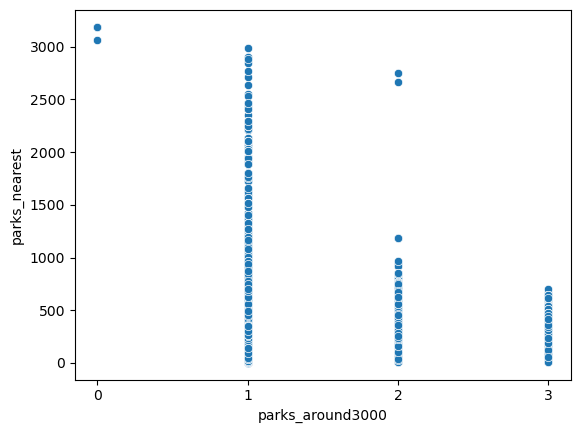

In [118]:
filtered_df = df[(df['parks_around3000'].notna()) & (df['parks_nearest'].notna())]
x = filtered_df['parks_around3000']
y = filtered_df['parks_nearest']

sns.scatterplot(data=filtered_df, x=x, y=y)

plt.xticks(range(int(filtered_df['parks_around3000'].min()), int(filtered_df['parks_around3000'].max()) + 1))
plt.show()

In [119]:
filtered_df = df[(df['parks_around3000'] > 0)]
print(f'Если значение в parks_around3000 > 0, то пропущенных в parks_nearest {len(filtered_df[(pd.isna(filtered_df['parks_nearest']))])}, максимальное значение равно {filtered_df['parks_nearest'].max()}') 

Если значение в parks_around3000 > 0, то пропущенных в parks_nearest 0, максимальное значение равно 2984.0


In [120]:
filtered_df = df[(df['parks_around3000'] == 0)]
print(f'Если значение в parks_around3000 == 0, то пропущенных в parks_nearest {len(filtered_df[(pd.isna(filtered_df['parks_nearest']))])}, максимальное значение равно {filtered_df['parks_nearest'].max()}') 

Если значение в parks_around3000 == 0, то пропущенных в parks_nearest 8966, максимальное значение равно 3190.0


In [121]:
filtered_df = df[(pd.isna(df['parks_around3000']))]
print(f'Если значение в parks_around3000 пропущено, то пропущенных в parks_nearest: {filtered_df['parks_nearest'].isna().sum()}, максимальное значение равно {filtered_df['parks_nearest'].max()}')

Если значение в parks_around3000 пропущено, то пропущенных в parks_nearest: 4780, максимальное значение равно nan


In [122]:
filtered_df = df[(pd.notna(df['parks_nearest']))]
print(f'Если значение в parks_nearest заполнено, то пропущенных в parks_around3000: {filtered_df['parks_around3000'].isna().sum()}, максимальное значение равно {filtered_df['parks_around3000'].max()}')

Если значение в parks_nearest заполнено, то пропущенных в parks_around3000: 0, максимальное значение равно 3.0


Исходя из результатов выше, можно разбить данные с пропусками в parks_nearest на две группы:

1 группа: известно, что в радиусе 3 км нет парка

2 группа: неизвестно, есть ли в радиусе 3 км парк, так как значение в parks_around3000 пропущено

Сделаем замену для первой группы в поле parks_nearest и укажем расстояние больше 3 км, например, 3100.
Для второй группы оставим пропуски.

In [124]:
#Известно, что в радиусе 3 км нет парка. Делаем замену:
filtered_df = df[(df['parks_around3000'] == 0)]
df.loc[(df['parks_nearest'].isna()) & (df['parks_around3000'] == 0), 'parks_nearest'] = 3100

In [125]:
#проверяем кол-во пропусков после замен
print(f'Кол-во пропусков в parks_around3000: {df['parks_around3000'].isna().sum()}')
print(f'Кол-во пропусков в parks_nearest: {df['parks_nearest'].isna().sum()}')

Кол-во пропусков в parks_around3000: 4780
Кол-во пропусков в parks_nearest: 4780


#### ponds_nearest и ponds_around3000

In [127]:
# Просмотр уникальных значений
df['ponds_nearest'].value_counts()

ponds_nearest
427.0     54
433.0     38
454.0     35
564.0     34
303.0     34
440.0     28
474.0     28
733.0     26
756.0     26
400.0     25
196.0     25
755.0     24
351.0     24
330.0     24
982.0     23
429.0     23
865.0     23
657.0     22
516.0     22
359.0     22
935.0     22
623.0     22
372.0     22
503.0     22
471.0     22
874.0     21
287.0     21
522.0     21
274.0     21
434.0     21
439.0     21
31.0      21
896.0     21
153.0     20
136.0     20
534.0     20
527.0     20
665.0     20
582.0     20
712.0     20
579.0     20
407.0     20
651.0     19
654.0     19
246.0     19
132.0     19
177.0     19
485.0     19
232.0     19
825.0     19
170.0     19
502.0     18
649.0     18
930.0     18
478.0     18
571.0     18
399.0     18
411.0     17
444.0     17
592.0     17
118.0     17
333.0     17
859.0     17
645.0     17
213.0     17
145.0     17
606.0     17
491.0     17
652.0     17
507.0     17
557.0     17
690.0     17
162.0     17
552.0     17
593.0     17
611.0     1

In [128]:
df['ponds_around3000'].value_counts()

ponds_around3000
0.0    8130
1.0    4939
2.0    1609
3.0    1140
Name: count, dtype: int64

Все шаги выполним аналогично тому, что сделали для двух параметров выше:
Проверим зависимость между столбцами "ponds_around3000" - число водоемов в радиусе 3 км и "ponds_nearest" - расстояние до ближайшего водоема (м).

In [130]:
filtered_df = df[(df['ponds_around3000'] > 0)]
print(f'Если значение в ponds_around3000 > 0, то пропущенных в ponds_nearest {len(filtered_df[(pd.isna(filtered_df['ponds_nearest']))])}, максимальное значение равно {filtered_df['ponds_nearest'].max()}') 

Если значение в ponds_around3000 > 0, то пропущенных в ponds_nearest 0, максимальное значение равно 1344.0


In [131]:
filtered_df = df[(df['ponds_around3000'] == 0)]
print(f'Если значение в ponds_around3000 == 0, то пропущенных в ponds_nearest {len(filtered_df[(pd.isna(filtered_df['ponds_nearest']))])}, максимальное значение равно {filtered_df['ponds_nearest'].max()}') 

Если значение в ponds_around3000 == 0, то пропущенных в ponds_nearest 8130, максимальное значение равно nan


In [132]:
filtered_df = df[(pd.isna(df['ponds_around3000']))]
print(f'Если значение в ponds_around3000 пропущено, то пропущенных в ponds_nearest: {filtered_df['ponds_nearest'].isna().sum()}, максимальное значение равно {filtered_df['ponds_nearest'].max()}')

Если значение в ponds_around3000 пропущено, то пропущенных в ponds_nearest: 4780, максимальное значение равно nan


In [133]:
filtered_df = df[(pd.notna(df['ponds_nearest']))]
print(f'Если значение в parks_nearest заполнено, то пропущенных в ponds_around3000: {filtered_df['ponds_around3000'].isna().sum()}, максимальное значение равно {filtered_df['ponds_around3000'].max()}')

Если значение в parks_nearest заполнено, то пропущенных в ponds_around3000: 0, максимальное значение равно 3.0


Cделаем замены по аналогии со столбцами "parks_around3000" и "parks_nearest"

In [135]:
#1 Так как в ponds_nearest всегда NaN, когда ponds_around3000 = 0, заменим в этом случае пропуски фиксированным значением 3100
df.loc[(df['ponds_nearest'].isna()) & (df['ponds_around3000'] == 0), 'ponds_nearest'] = 3100

In [136]:
#проверяем кол-во пропусков после замен
print(f'Кол-во пропусков в ponds_around3000: {df['ponds_around3000'].isna().sum()}')
print(f'Кол-во пропусков в ponds_nearest: {df['ponds_nearest'].isna().sum()}')

Кол-во пропусков в ponds_around3000: 4780
Кол-во пропусков в ponds_nearest: 4780


### Результаты обработки

In [138]:
print(f'Количество строк до обработки = {len_df_start}, количество строк после обработки = {len(df)}')

Количество строк до обработки = 23699, количество строк после обработки = 20598


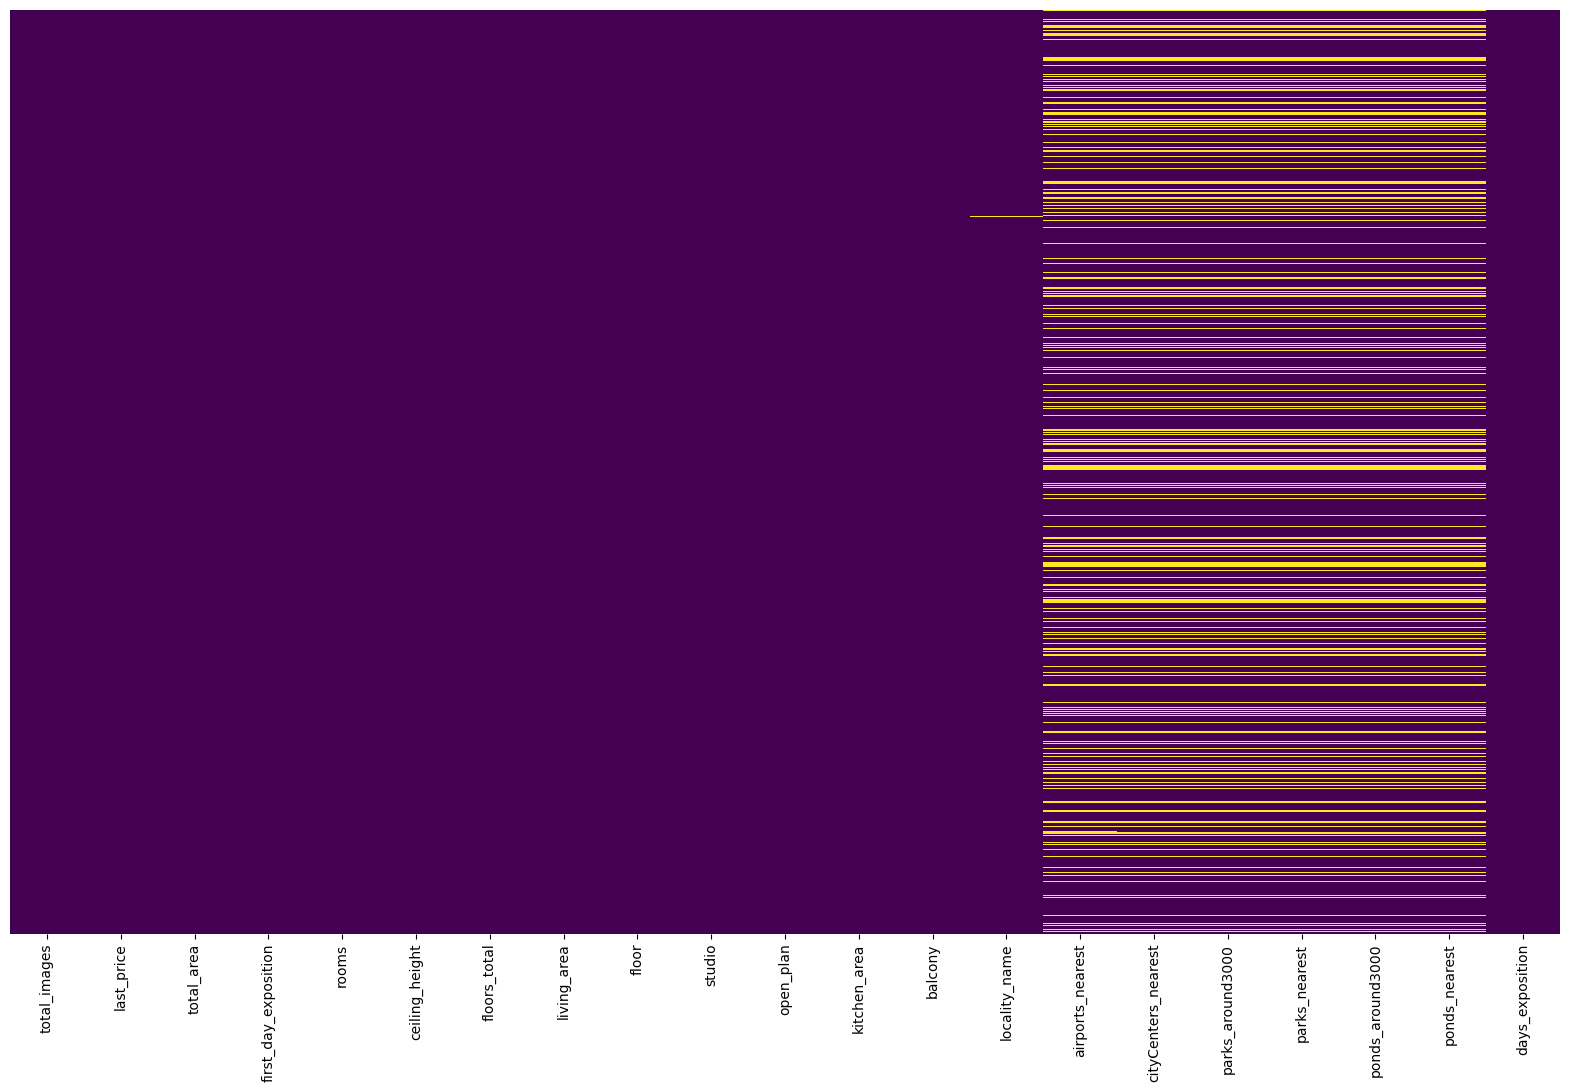

In [139]:
#Карта пропусков
fig, ax = plt.subplots(figsize=(20,12))
sns_heatmap = sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [140]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20598 entries, 0 to 23698
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          20598 non-null  int64         
 1   last_price            20598 non-null  float64       
 2   total_area            20598 non-null  float64       
 3   first_day_exposition  20598 non-null  datetime64[ns]
 4   rooms                 20598 non-null  int64         
 5   ceiling_height        20598 non-null  float64       
 6   floors_total          20598 non-null  int32         
 7   living_area           20598 non-null  float64       
 8   floor                 20598 non-null  int64         
 9   studio                20598 non-null  bool          
 10  open_plan             20598 non-null  bool          
 11  kitchen_area          20598 non-null  float64       
 12  balcony               20598 non-null  int32         
 13  locality_name        

## Этап 2. Добавление новых признаков

Добавим новые временные признаки (год, месяц, день недели публикации объявления), признак цена за квадратный метр, тип этажа квартиры (первый, последний, первый и последний, другой)

In [143]:
df['year'] = df['first_day_exposition'].dt.year
df['month'] = df['first_day_exposition'].dt.month
df['weekday'] = df['first_day_exposition'].dt.weekday
df['price_per_m2'] = (df['last_price'] / df['total_area']).round(2)
df['floor_type'] = df.apply(lambda row: 'Первый и последний' if row['floor'] == 1 and row['floors_total'] == 1 else ('Первый' if row['floor'] == 1 else ('Последний' if row['floor'] == row['floors_total'] else 'Другой')),axis=1)

In [144]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,year,month,weekday,price_per_m2,floor_type
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,False,False,25.0,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,0,2019,3,3,120370.37,Другой
1,7,3350000.0,40.4,2018-12-04,1,2.71,11,18.6,1,False,False,11.0,2,поселок Шушары,12817.0,18603.0,0.0,3100.0,0.0,3100.0,81,2018,12,1,82920.79,Первый
2,10,5196000.0,56.0,2015-08-20,2,2.71,5,34.3,4,False,False,8.3,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558,2015,8,3,92785.71,Другой
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,False,False,41.0,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121,2018,6,1,100000.00,Другой
5,10,2890000.0,30.4,2018-09-10,1,2.71,12,14.4,5,False,False,9.1,0,городской поселок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55,2018,9,0,95065.79,Другой


In [252]:
#сохраним обработтанве данные в новый датасет
df.to_csv('real_estate_processed.csv', index=False)